In [26]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [27]:
df = pd.read_csv("data/final.csv")

In [28]:
df.columns[~df.columns.str.startswith("embedding")]


Index(['Unnamed: 0', 'source', 'domain', 'chart', 'region', 'date', 'position',
       'title', 'artist', 'scraped_at', 'track_name', 'artists', 'album_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'lyrics', 'lyrics_language', 'happiness_from_lyrics',
       'track_id', 'h_track', 'catharsis_score'],
      dtype='object')

In [29]:
df.shape

(1550, 250)

In [30]:
df = df.drop(columns=['Unnamed: 0', 'position'])
df = df.dropna(subset=["happiness_from_lyrics"])
df = df.dropna(axis=1, how="any")

target_col = "popularity"
X = df.drop(columns=[target_col])
y = df[target_col]

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = ["lyrics_language", "track_genre"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Outlier Removal strategies

In [31]:
def remove_outliers_iqr(X, y, numeric_cols):
    """Supprime les outliers univariés selon IQR."""
    mask = pd.Series(True, index=X.index)
    for col in numeric_cols:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        mask &= (X[col] >= Q1 - 5*IQR) & (X[col] <= Q3 + 5*IQR)
    return X[mask], y[mask]

def remove_outliers_isolation_forest(X, y, numeric_cols):
    """Supprime les outliers multivariés selon Isolation Forest."""
    iso = IsolationForest(contamination=0.05, random_state=42)
    iso.fit(X[numeric_cols])
    mask = iso.predict(X[numeric_cols]) == 1
    return X[mask], y[mask]

outlier_strategies = {
    "none": lambda X, y: (X, y),
    "univariate_iqr": lambda X, y: remove_outliers_iqr(X, y, numeric_cols),
    "multivariate_iforest": lambda X, y: remove_outliers_isolation_forest(X, y, numeric_cols)
}

### Preprocessing and models

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

models = {
    "Lasso": Lasso(alpha=0.1, random_state=42, max_iter=10000),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

### Evaluation

In [33]:
results = []

for strategy_name, strategy_func in outlier_strategies.items():
    X_train_clean, y_train_clean = strategy_func(X_train, y_train)
    
    for model_name, model in models.items():
        pipeline = Pipeline([
            ("preprocessing", preprocessor),
            ("model", model)
        ])
        
        pipeline.fit(X_train_clean, y_train_clean)
        
        y_train_pred = pipeline.predict(X_train_clean)
        y_test_pred = pipeline.predict(X_test)
        
        train_rmse = np.sqrt(mean_squared_error(y_train_clean, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_r2 = pipeline.score(X_train_clean, y_train_clean)
        test_r2 = pipeline.score(X_test, y_test)
        
        cv_rmse = -cross_val_score(
            pipeline, X_train_clean, y_train_clean,
            cv=5, scoring="neg_root_mean_squared_error"
        ).mean()
        cv_r2 = cross_val_score(
            pipeline, X_train_clean, y_train_clean,
            cv=5, scoring="r2"
        ).mean()
        
        results.append({
            "outlier_strategy": strategy_name,
            "model": model_name,
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "train_r2": train_r2,
            "test_r2": test_r2,
            "cv_rmse": cv_rmse,
            "cv_r2": cv_r2
        })


In [34]:
results_df = pd.DataFrame(results)
print(results_df.sort_values("test_rmse"))

       outlier_strategy             model  train_rmse  test_rmse  train_r2  \
8  multivariate_iforest  GradientBoosting    8.560066  19.950916  0.857190   
2                  none  GradientBoosting    9.107949  20.147724  0.839434   
1                  none             Ridge   15.387088  20.605155  0.541726   
0                  none             Lasso   17.026911  20.640036  0.438844   
5        univariate_iqr  GradientBoosting    7.195505  20.644954  0.897079   
6  multivariate_iforest             Lasso   17.049338  20.957201  0.433473   
7  multivariate_iforest             Ridge   15.388641  21.072500  0.538463   
4        univariate_iqr             Ridge   14.792132  23.580581  0.565045   
3        univariate_iqr             Lasso   16.353421  61.462055  0.468382   

    test_r2    cv_rmse     cv_r2  
8  0.179874  20.871496  0.146442  
2  0.163614  20.409232  0.187549  
1  0.125204  21.912521  0.064443  
0  0.122240  21.425284  0.106727  
5  0.121822  21.205779  0.097003  
6  0.0950

-------

## Interpretability

In [235]:
from sklearn.inspection import permutation_importance
import pandas as pd

pipe = pipelines['gboost_none']  
X_train, y_train, X_test, y_test = DATASETS['none']

result = permutation_importance(
    pipe, X_test, y_test, 
    n_repeats=10, random_state=42, scoring='r2'
)

feature_names = pipe.named_steps['preprocessing'].get_feature_names_out()
importances = pd.Series(result.importances_mean, index=feature_names)


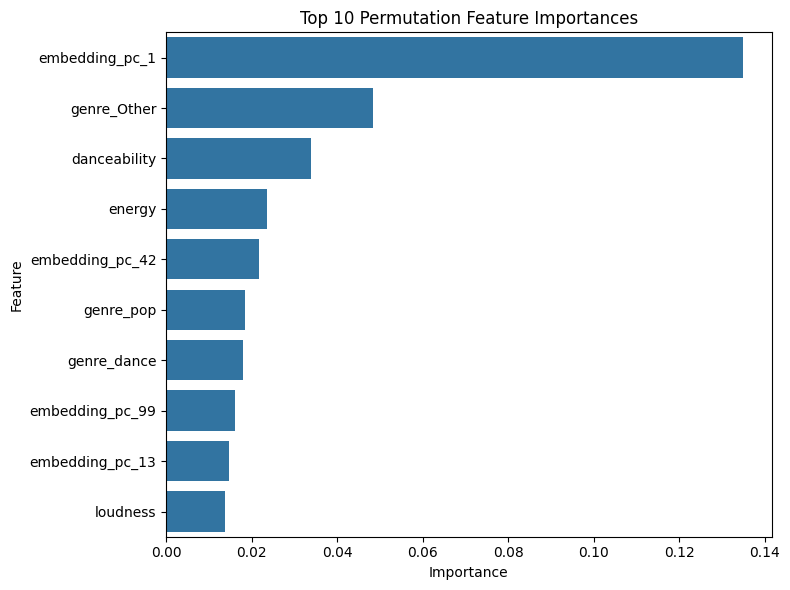

In [236]:
k = 10  # number of top features to display
top_features = importances.abs().sort_values(ascending=False).head(k)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title(f"Top {k} Permutation Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


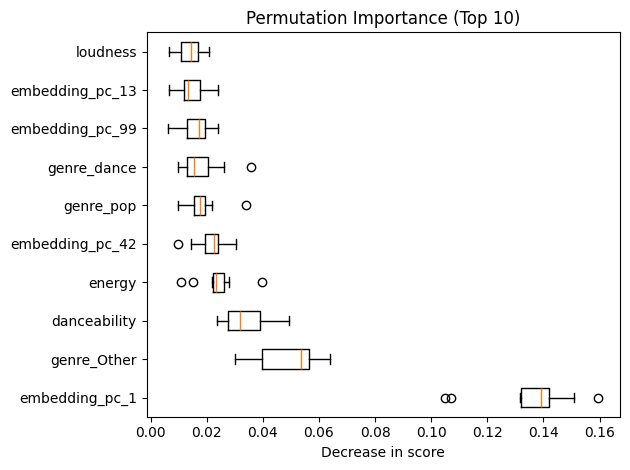

In [238]:
import matplotlib.pyplot as plt

sorted_idx = result.importances_mean.argsort()[::-1][:10]

plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    tick_labels=feature_names[sorted_idx]
)
plt.title("Permutation Importance (Top 10)")
plt.xlabel("Decrease in score")
plt.tight_layout()
plt.show()


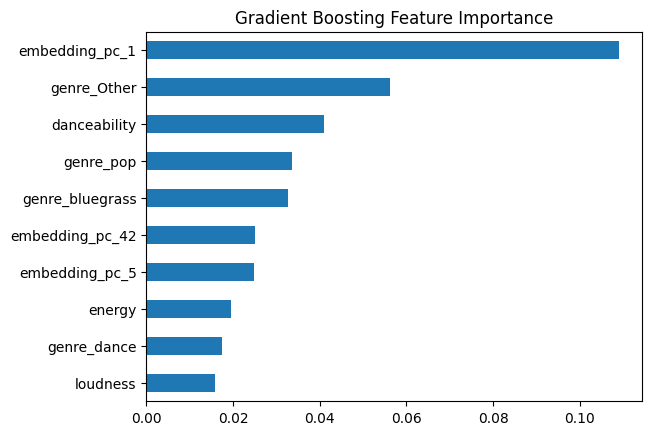

In [239]:
import pandas as pd

model = pipe.named_steps['model']
importances = pd.Series(
    model.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

importances.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Gradient Boosting Feature Importance")
plt.show()


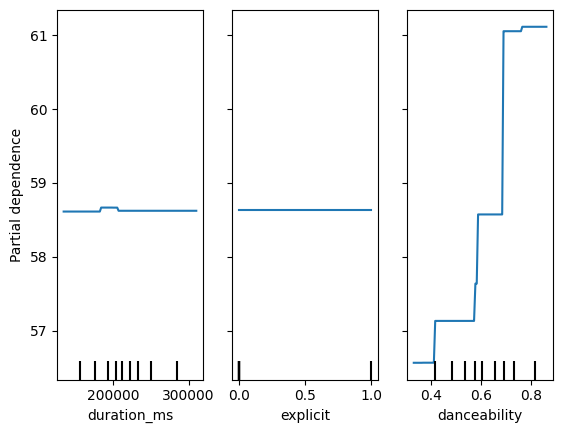

In [240]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    pipe,
    X_test,
    features=[0, 1, 2],  # indices of top features
    feature_names=feature_names
)
plt.show()


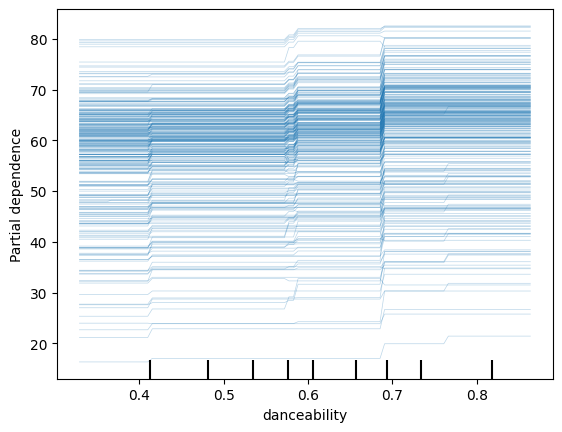

In [245]:
PartialDependenceDisplay.from_estimator(
    pipe,
    X_test,
    features=[2],
    kind="individual",
    feature_names=feature_names
)
plt.show()


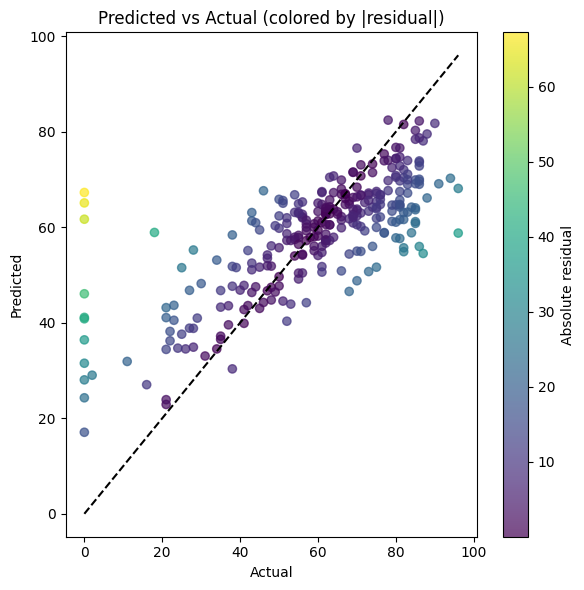

In [242]:
y_pred = pipe.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(6, 6))
sc = plt.scatter(
    y_test,
    y_pred,
    c=abs(residuals),
    cmap="viridis",
    alpha=0.7
)

plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--",
    color="black"
)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (colored by |residual|)")
plt.colorbar(sc, label="Absolute residual")
plt.tight_layout()
plt.show()


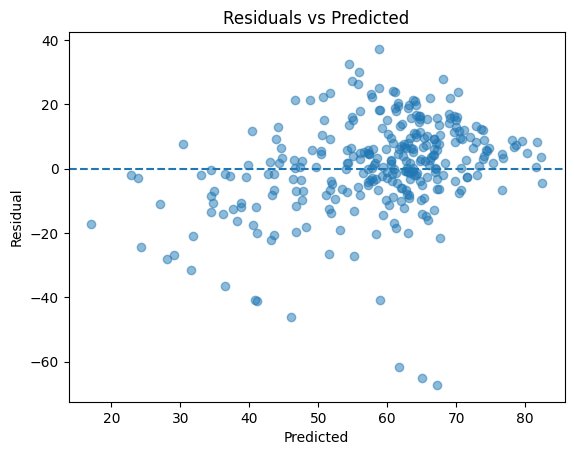

In [243]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.show()
